# HW 7

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import sklearn.cluster
from scipy.cluster.vq import kmeans, vq
!pip install cartopy
import cartopy.crs as ccrs
import cartopy as ct
!pip install cmocean
import cmocean
import seaborn as sns

In [53]:
data = xr.open_dataset('/content/drive/MyDrive/Classes/OA/HW7/tas_DJFdays_PAMIP_CESM2_NorthAmerica.nc')
data

<xarray.Dataset> Size: 40MB
Dimensions:                        (latitude: 45, longitude: 61, time: 1800)
Coordinates:
  * latitude                       (latitude) float64 360B 1.0 3.0 ... 87.0 89.0
  * longitude                      (longitude) float64 488B 200.0 ... 320.0
  * time                           (time) int64 14kB 1 2 3 4 ... 1798 1799 1800
Data variables:
    __xarray_dataarray_variable__  (time, latitude, longitude) float64 40MB ...

In [54]:
T = data['__xarray_dataarray_variable__'].values
lat = data['latitude'].values
lon = data['longitude'].values

In [55]:
1800/90 # 90 days per year > 20 years total

20.0

In [56]:
T.shape[0], T.shape[1], T.shape[2] # time, lat, lon

(1800, 45, 61)

In [57]:
numclust = 4          # number of clusters to fit
n_iters_vec = [20,]     # number of full iterations run, then take the best one

dist_vec = np.asarray([])
for n_iters in n_iters_vec:
 #  clusters/nodes/centroids, sum distance/quantization error = kmeans(input data, #clusters, #iterations)
    clusters, dist = kmeans(T.reshape(T.shape[0],T.shape[1]*T.shape[2]), numclust, iter=n_iters) # flatten location
    classes, _ = vq(T.reshape(T.shape[0], T.shape[1]*T.shape[2]), clusters)

    dist_vec = np.append(dist_vec,dist)

print('clusters shape = ' + str(clusters.shape))
print('classes shape = ' + str(classes.shape))

clusters shape = (4, 2745)
classes shape = (1800,)


In [75]:
def drawOnGlobe(ax, data, lats, lons, cmap='coolwarm', vmin=None, vmax=None, inc=None, cbarBool=True, contourMap=[], contourVals = [], fastBool=False, extent='both'):

    data_crs = ct.crs.PlateCarree()
    data_cyc, lons_cyc = add_cyclic_point(data, coord=lons) #fixes white line by adding point#data,lons#ct.util.add_cyclic_point(data, coord=lons) #fixes white line by adding point

    ax.set_global()
    ax.coastlines(linewidth = 1.2, color='black')
    if(fastBool):
        image = ax.pcolormesh(lons_cyc, lats, data_cyc, transform=data_crs, cmap=cmap)
    else:
        image = ax.pcolor(lons_cyc, lats, data_cyc, transform=data_crs, cmap=cmap)

    if(np.size(contourMap) !=0 ):
        contourMap_cyc, __ = add_cyclic_point(contourMap, coord=lons) #fixes white line by adding point
        ax.contour(lons_cyc,lats,contourMap_cyc,contourVals, transform=data_crs, colors='fuchsia')

    if(cbarBool):
        cb = plt.colorbar(image, shrink=.75, orientation="vertical", pad=.02, extend=extent, label="T' (C)")
        cb.ax.tick_params(labelsize=6)
    else:
        cb = None

    image.set_clim(vmin,vmax)

    return cb, image

In [76]:
def add_cyclic_point(data, coord=None, axis=-1):

    # had issues with cartopy finding utils so copied for myself

    if coord is not None:
        if coord.ndim != 1:
            raise ValueError('The coordinate must be 1-dimensional.')
        if len(coord) != data.shape[axis]:
            raise ValueError('The length of the coordinate does not match '
                             'the size of the corresponding dimension of '
                             'the data array: len(coord) = {}, '
                             'data.shape[{}] = {}.'.format(
                                 len(coord), axis, data.shape[axis]))
        delta_coord = np.diff(coord)
        if not np.allclose(delta_coord, delta_coord[0]):
            raise ValueError('The coordinate must be equally spaced.')
        new_coord = np.ma.concatenate((coord, coord[-1:] + delta_coord[0]))
    slicer = [slice(None)] * data.ndim
    try:
        slicer[axis] = slice(0, 1)
    except IndexError:
        raise ValueError('The specified axis does not correspond to an '
                         'array dimension.')
    new_data = np.ma.concatenate((data, data[tuple(slicer)]), axis=axis)
    if coord is None:
        return_value = new_data
    else:
        return_value = new_data, new_coord
    return return_value

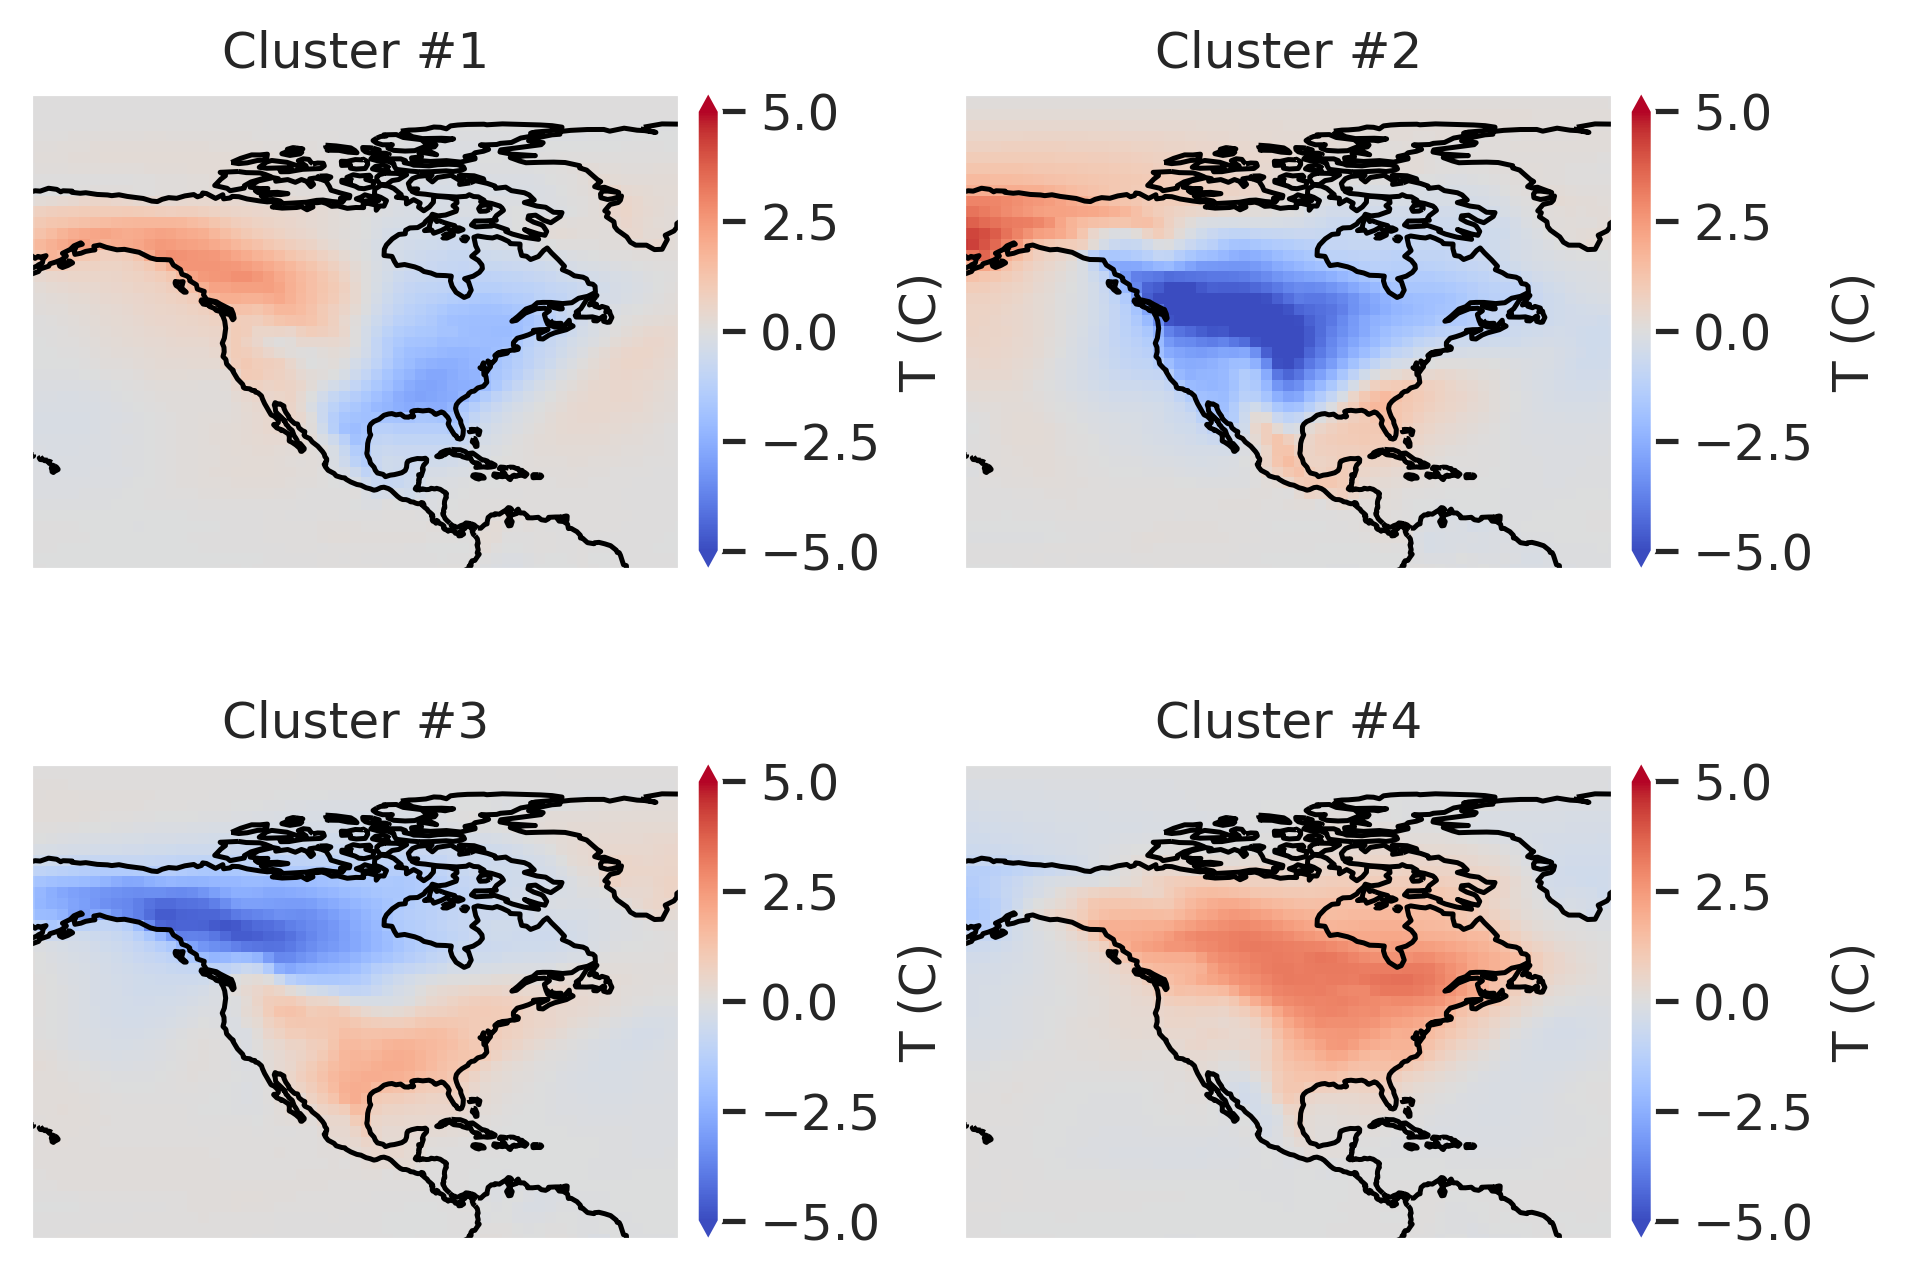

In [78]:
maxVal = 5.
mapProj = ccrs.PlateCarree()
fastBool = True
titleSize = 12
# cmap = cmocean.cm.balance

extent = [np.min(lon), np.max(lon), np.min(lat), np.max(lat)]

plt.figure(dpi=300)

for cluster in np.arange(numclust):
    ax = plt.subplot(2, int(np.ceil(numclust/2)), cluster+1, projection=mapProj)
    xplot = clusters[cluster,:].reshape(len(lat),len(lon))
    cb, image = drawOnGlobe(ax, xplot, np.squeeze(lat), np.squeeze(lon), vmin = -maxVal, vmax=maxVal, cbarBool=True, fastBool=fastBool)
    ax.set_extent(extent)
    cb.set_label('T (C)', fontsize=titleSize)
    cb.ax.tick_params(labelsize=titleSize)
    plt.title('Cluster #' + str(cluster+1), fontsize=titleSize)
plt.tight_layout()
plt.show()

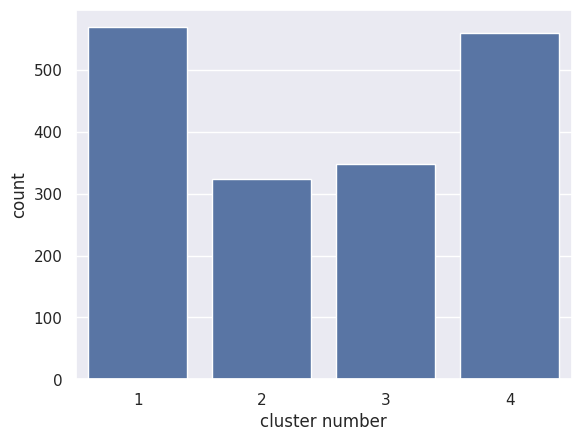

In [61]:
da_classes = pd.DataFrame(data={'class':classes+1})

sns.set(style="darkgrid")
ax = sns.countplot(data=da_classes,x='class')
plt.xlabel('cluster number')
plt.show()

In [62]:
len(classes)

1800

In [88]:
cluster_indices = np.where(classes == 3)[0]
cluster_data = T[:, cluster_indices // T.shape[2], cluster_indices % T.shape[2]]

In [81]:
np.shape(cluster_data)

(1800, 569)

In [84]:
np.shape(cluster_data)

(1800, 324)

In [87]:
np.shape(cluster_data)

(1800, 348)

In [89]:
np.shape(cluster_data)

(1800, 559)

In [91]:
(559-348)/559

0.3774597495527728

## Notes
* Clustering entire maps by time
* Each cluster has a segment of the 20 years of daily data
* Each map depicts the centroid of the maps within the cluster?